In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt;

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("pepper_disease",
                                                            shuffle=True,
                                                   image_size=(256,256),
                                                   batch_size=32)

Found 2475 files belonging to 2 classes.


In [5]:
class_names=dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [6]:
len(dataset)

78

In [12]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


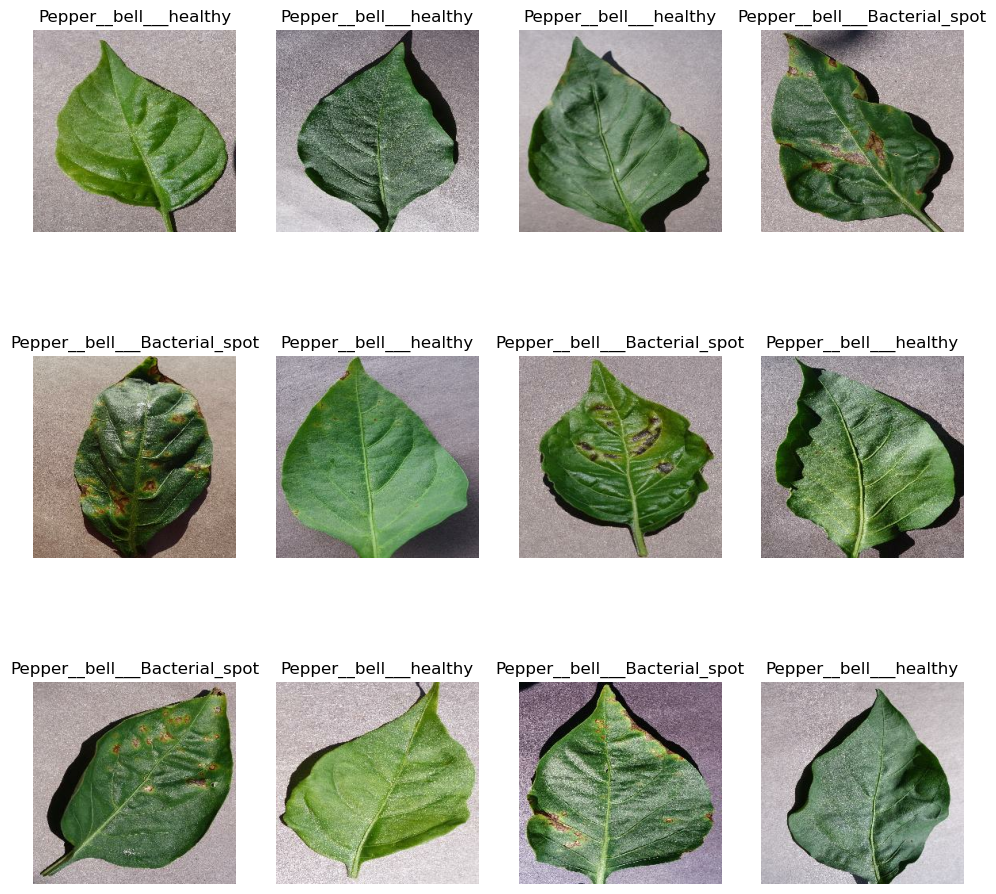

In [14]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
  

In [15]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    
    
    return train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds =get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

62

In [19]:
len(val_ds)

7

In [20]:
len(test_ds)

9

In [21]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [27]:
# data augumentation
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

In [85]:
channels=3
input_shape=(32,256,256,channels)
n_classes=2


model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #cnn
    layers.Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    #dense
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(30,activation="relu"),
    layers.Dense(10,activation="relu"),
    layers.Dense(2,activation="softmax")       
])

model.build(input_shape=input_shape)

In [86]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [87]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [88]:
pepper_his=model.fit(train_ds,epochs=10,
         batch_size=32,
         verbose=1,
         validation_data=val_ds)

Epoch 1/10
62/62 [==============================] - 79s 1s/step - loss: 0.4877 - accuracy: 0.7565 - val_loss: 0.3043 - val_accuracy: 0.8661
Epoch 2/10
62/62 [==============================] - 84s 1s/step - loss: 0.2452 - accuracy: 0.9109 - val_loss: 0.1709 - val_accuracy: 0.9375
Epoch 3/10
62/62 [==============================] - 80s 1s/step - loss: 0.2282 - accuracy: 0.9384 - val_loss: 0.3202 - val_accuracy: 0.8839
Epoch 4/10
62/62 [==============================] - 99s 2s/step - loss: 0.1708 - accuracy: 0.9521 - val_loss: 0.0784 - val_accuracy: 0.9643
Epoch 5/10
62/62 [==============================] - 131s 2s/step - loss: 0.1578 - accuracy: 0.9618 - val_loss: 0.2870 - val_accuracy: 0.8973
Epoch 6/10
62/62 [==============================] - 131s 2s/step - loss: 0.1351 - accuracy: 0.9679 - val_loss: 0.0548 - val_accuracy: 0.9777
Epoch 7/10
62/62 [==============================] - 127s 2s/step - loss: 0.0630 - accuracy: 0.9862 - val_loss: 0.0659 - val_accuracy: 0.9777
Epoch 8/10
62/62 

In [89]:
model.evaluate(test_ds)

9/9 [==============================] - 3s 379ms/step - loss: 0.0653 - accuracy: 0.9722


[0.06534436345100403, 0.9722222089767456]

In [90]:
pepper_his.params

{'verbose': 1, 'epochs': 10, 'steps': 62}

In [91]:
pepper_his.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [92]:
acc=pepper_his.history["accuracy"]
val_acc=pepper_his.history["val_accuracy"]
loss=pepper_his.history["loss"]
val_loss=pepper_his.history["val_loss"]

Text(0.5, 1.0, 'Training and validation loss')

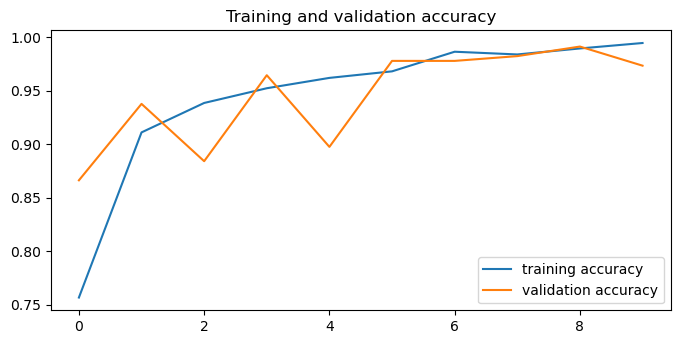

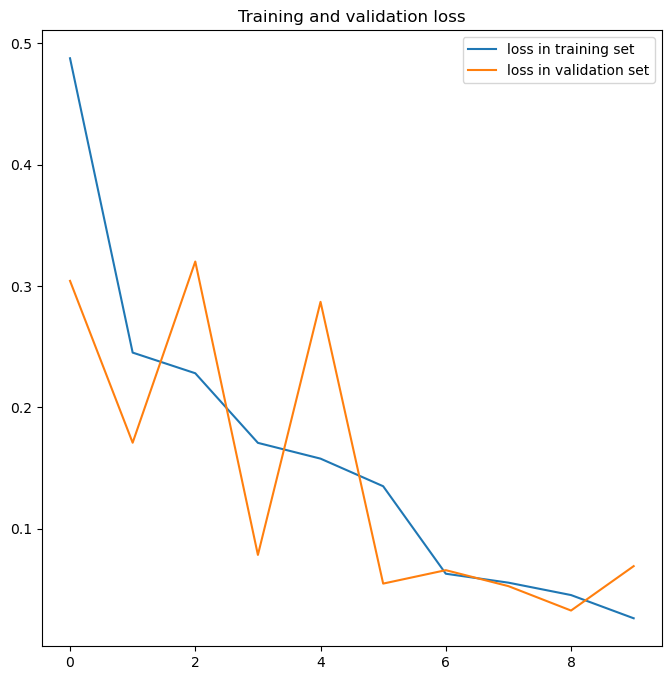

In [93]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(range(10),acc,label="training accuracy")
plt.plot(range(10),val_acc,label="validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and validation accuracy")




plt.figure(figsize=(8,8))
plt.plot(range(10),loss,label="loss in training set")
plt.plot(range(10),val_loss,label="loss in validation set")
plt.legend(loc="upper right")
plt.title("Training and validation loss")


first image to predict
actual label: Pepper__bell___healthy
1/1 [==============================] - 0s 342ms/step
predicted_label: Pepper__bell___healthy


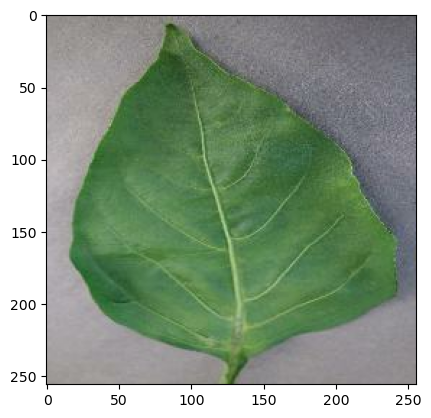

In [96]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    first_label=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction=model.predict(images_batch);
    print("predicted_label:",class_names[np.argmax(batch_prediction[0])]);
    

1/1 [==============================] - 0s 300ms/step


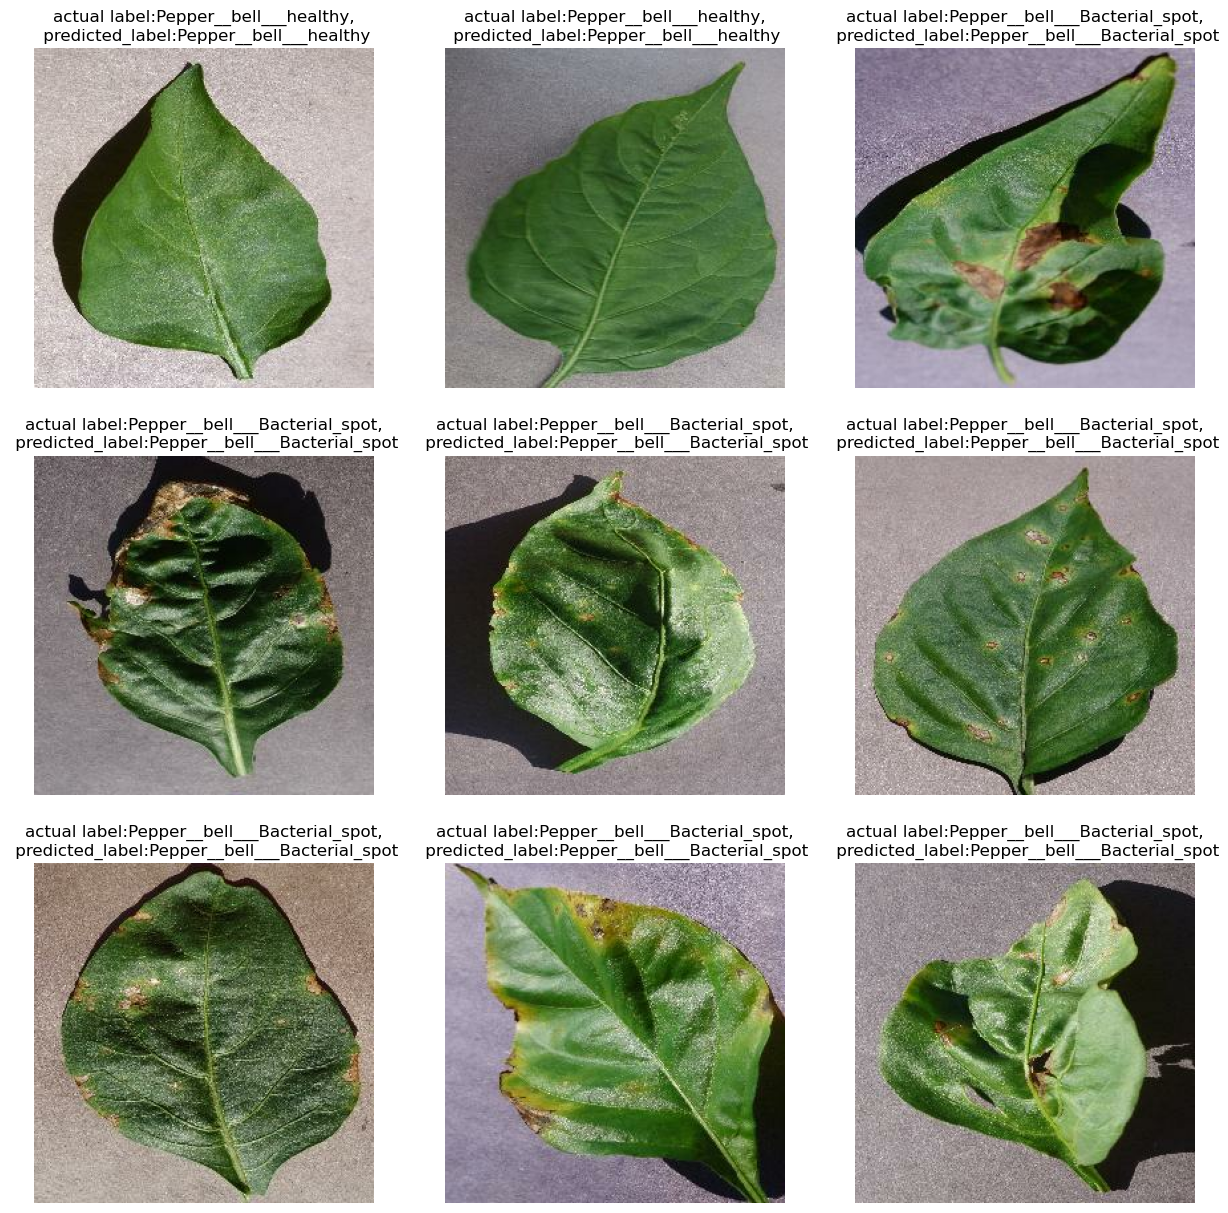

In [107]:
import numpy as np
plt.figure(figsize=(15,15))
for images_batch,labels_batch in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        first_image=images_batch[i].numpy().astype("uint8")
        first_label=labels_batch[i].numpy()
        #print(" actual vs predict")
        plt.imshow(first_image)
        #print("actual label:",class_names[first_label])
        batch_prediction=model.predict(images_batch);
        #print("predicted_label:",class_names[np.argmax(batch_prediction[i])])
        plt.axis("off")
        
        plt.title(f"actual label:{class_names[first_label]},\n predicted_label:{class_names[np.argmax(batch_prediction[i])]}")
        

In [108]:
model_version=1
model.save(f"../models_pepper_disease/{model_version}")

INFO:tensorflow:Assets written to: ../models_pepper_disease/1/assets


INFO:tensorflow:Assets written to: ../models_pepper_disease/1/assets
